In [1]:
import numpy as np
import pickle
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.
/home/bhrt/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bhrt/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bhrt/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bhrt/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [3]:
filename = "Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)

In [4]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

In [5]:
# parse descriptions
descriptions = load_descriptions(doc)
#print('Loaded: %d ' % len(descriptions))

In [6]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [7]:
# clean descriptions
clean_descriptions(descriptions)


In [8]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [9]:
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
#print('Original Vocabulary Size: %d' % len(vocabulary))


In [10]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [11]:
save_descriptions(descriptions, 'descriptions.txt')

In [12]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
#print('Dataset: %d' % len(train))

In [13]:
# Below path contains all the images
images = ''
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [14]:

# Below file conatains the names of images to be used in test data
#test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
#test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
#test_img = []

#for i in img: # img is list of full path names of all images
 #   if i[len(images):] in test_images: # Check if the image belongs to test set
  #      test_img.append(i) # Add it to the list of test images
test_img = []

test_img.append('blind.jpg')

In [15]:
import pickle

In [16]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [17]:
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
#print('Descriptions: train=%d' % len(train_descriptions))

In [18]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [19]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')
#model = keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, depth_multiplier=1, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

In [20]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)


In [21]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [22]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
#print("Time taken in seconds =", time()-start)

In [23]:
# Save the bottleneck test features to disk
import pickle
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)


In [24]:

train_features = load(open("encoded_train_images.pkl", "rb"))
#print('Photos: train=%d' % len(train_features))


In [25]:


# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)


30000

In [26]:

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1


In [27]:
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
#print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

In [28]:

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1


In [29]:


vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size


1652

In [30]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [31]:

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


In [32]:
# determine the maximum sequence length
max_length = max_length(train_descriptions)
#print('Description Length: %d' % max_length)


In [33]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0


In [34]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,200, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [35]:
# model.summary()
# model.layers[2]


In [36]:
embedding_matrix = np.zeros((vocab_size, 200))
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [38]:
model.load_weights('model_30.h5')


In [39]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [40]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

[0.29223752 0.93163455 0.6954422  ... 0.59180576 0.9507625  0.09145934]
2048
blind.jpg


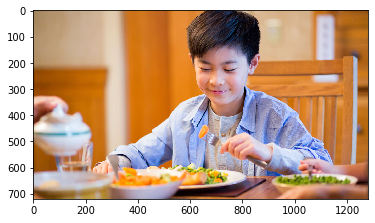




Generated Caption is:



woman in white shirt and black shirt is sitting in chair









In [43]:
z=0
pic = list(encoding_test.keys())[z]
print(encoding_test[pic])
print(encoding_test[pic].size)
image = encoding_test[pic].reshape((1,2048))
print(images+pic)
x=plt.imread("blind.jpg")
plt.imshow(x)
plt.show()
print("\n\n\nGenerated Caption is:\n\n\n")
print(greedySearch(image))
print("\n\n\n\n\n\n")

In [51]:
from gtts import gTTS 
  
# This module is imported so that we can  
# play the converted audio 
import os 
  
# The text that you want to convert to audio 

mytext = greedySearch(image)


# Language in which you want to convert 
language = 'en'
  

myobj = gTTS(text=mytext, lang=language, slow=False) 
  
# Saving the converted audio in a mp3 file named 
# welcome  
myobj.save("welcome.mp4") 
  
# Playing the converted file ]
class Video(object):
    def __init__(self,path):
        self.path = path

#     def play(self):
#         from os import startfile
#         startfile(self.path)

class Movie_MP4(Video):
    type = "MP4"

movie = Movie_MP4("welcome.mp4")
movie.play()

AttributeError: 'Movie_MP4' object has no attribute 'play'

In [53]:
from pygame import mixer
mixer.init()
sound = mixer.Sound("welcome.mp4")
sound.play()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


error: Unable to open file 'welcome.mp4'